# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

## **3. Baseline Models**

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **3.1 Data Splitting**

In [2]:
imis_df = pd.read_parquet("/kaggle/input/data-rf/cleaned_data.parquet")

In [3]:
imis_df.columns

Index(['datum', 'station_code', 'sector_id', 'warnreg', 'elevation_station',
       'forecast_initial_date', 'forecast_end_date', 'dangerLevel',
       'elevation_th', 'set', 'Qs', 'Ql', 'Qg0', 'LWR_net', 'ISWR', 'pAlbedo',
       'ISWR_diff', 'TA', 'TSS_mod', 'RH', 'VW', 'VW_drift', 'DW', 'MS_Snow',
       'HS_mod', 'hoar_size', 'wind_trans24', 'wind_trans24_7d',
       'wind_trans24_3d', 'HN24', 'HN72_24', 'HN24_7d', 'MS_water', 'MS_Wind',
       'MS_Rain', 'MS_SN_Runoff', 'MS_Sublimation', 'MS_Evap', 'Sclass2',
       'zSd_mean', 'Sd', 'zSn', 'Sn', 'zSs', 'Ss', 'zS5', 'sk38_pwl',
       'sn38_pwl', 'sk38_pwl_100', 'sn38_pwl_100', 'ccl_pwl_100', 'Pen_depth',
       'min_ccl_pen', 'lon', 'lat', 'delta_elevation', 'month', 'year',
       'delta_TA_24h', 'days_since_last_storm', 'faceting_risk_days_14',
       'relative_load_3d'],
      dtype='object')

In [6]:
imis_df['datum'] = pd.to_datetime(imis_df['datum'], format='%Y-%m-%d')

In [7]:
# Remove non-predictive features
features_to_drop = ['sector_id', 'warnreg', 'forecast_initial_date', 'forecast_end_date',
                   'year', 'lon', 'lat']
imis_df = imis_df.drop(columns=features_to_drop)

In [8]:
imis_df_sorted = imis_df.sort_values(['station_code', 'datum']).copy()

### **3.2 Naive Model**

In [9]:
# 1. Prepare Data
imis_df_sorted = imis_df_sorted.sort_values(['station_code', 'datum'])

# Create the lag (Yesterday's danger level)
imis_df_sorted['dangerLevel_prev'] = imis_df_sorted.groupby('station_code')['dangerLevel'].shift(1)

In [10]:
# Test Set 
test_naive_df = imis_df_sorted[imis_df_sorted['set'] == 'test'].dropna(subset=['dangerLevel_prev'])

# Features & Targets
y_true_naive = test_naive_df['dangerLevel']
y_pred_naive = test_naive_df['dangerLevel_prev']

In [11]:
# 3. Calculate Metrics
acc = accuracy_score(y_true_naive, y_pred_naive)
bal_acc = balanced_accuracy_score(y_true_naive, y_pred_naive)
macro_f1 = f1_score(y_true_naive, y_pred_naive, average='macro')
weighted_f1 = f1_score(y_true_naive, y_pred_naive, average='weighted')

# Calculate per-class recall (Critical for DL 4)
recalls = recall_score(y_true_naive, y_pred_naive, average=None, labels=[1, 2, 3, 4])
class_4_recall = recalls[3] if len(recalls) >= 4 else 0.0

print(f"  Accuracy:          {acc:.2%}")
print(f"  Balanced Accuracy: {bal_acc:.2%}")
print(f"  Macro F1-Score:    {macro_f1:.4f}")
print(f"  Weighted F1-Score: {weighted_f1:.4f}")
print(f"  Class 4 Recall:    {class_4_recall:.2%}")

  Accuracy:          76.30%
  Balanced Accuracy: 66.49%
  Macro F1-Score:    0.6648
  Weighted F1-Score: 0.7630
  Class 4 Recall:    32.67%



Classification Report:
                  precision    recall  f1-score   support

         Low (1)       0.88      0.88      0.88     10051
    Moderate (2)       0.74      0.74      0.74     12862
Considerable (3)       0.71      0.71      0.71     10467
        High (4)       0.33      0.33      0.33       805

        accuracy                           0.76     34185
       macro avg       0.66      0.66      0.66     34185
    weighted avg       0.76      0.76      0.76     34185



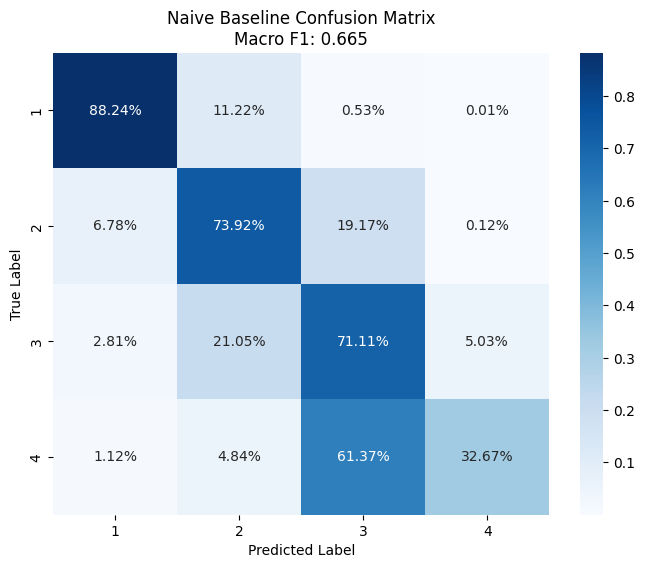

In [13]:
# 4. Visuals
print("\nClassification Report:")
print(classification_report(y_true_naive, y_pred_naive, target_names=['Low (1)', 'Moderate (2)', 'Considerable (3)', 'High (4)']))

# Confusion Matrix
cm = confusion_matrix(y_true_naive, y_pred_naive)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['1', '2', '3', '4'],
            yticklabels=['1', '2', '3', '4'])
plt.title(f'Naive Baseline Confusion Matrix\nMacro F1: {macro_f1:.3f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
# 5. Save Benchmark
naive_results = {
    'model': 'Naive (Persistence)',
    'macro_f1': macro_f1,
    'accuracy': acc,
    'class_4_recall': class_4_recall
}
print("\nNaive Benchmark Saved:", naive_results)


Naive Benchmark Saved: {'model': 'Naive (Persistence)', 'macro_f1': 0.6648120150895347, 'accuracy': 0.7629954658475939, 'class_4_recall': np.float64(0.3267080745341615)}


### **3.3 Random Forest Model**

Next, we focus 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [16]:
# 1. Data Splitting
# Ensure chronological order
imis_df_sorted = imis_df_sorted.sort_values(['station_code', 'datum'])
# Train Phase: Winters up to 2016
# Val Phase:   Winters 16/17 and 17/18 (Oct-May)
# Test Phase:  Winters 18/19 and 19/20 (Already marked as 'set'='test')

train_full = imis_df_sorted[imis_df_sorted['set'] == 'train'].copy()

# Create Validation Mask for 16/17 and 17/18
val_mask = (
    ((train_full['datum'] >= '2016-10-01') & (train_full['datum'] <= '2017-05-30')) |
    ((train_full['datum'] >= '2017-10-01') & (train_full['datum'] <= '2018-05-30'))
)

X_train_phase = train_full[~val_mask].drop(columns=['datum', 'station_code', 'dangerLevel', 'set'], errors='ignore')
y_train_phase = train_full[~val_mask]['dangerLevel']

X_val_phase = train_full[val_mask].drop(columns=['datum', 'station_code', 'dangerLevel', 'set'], errors='ignore')
y_val_phase = train_full[val_mask]['dangerLevel']

# Test Set (The final exam)
test_df = imis_df_sorted[imis_df_sorted['set'] == 'test']
X_test = test_df.drop(columns=['datum', 'station_code', 'dangerLevel', 'set'], errors='ignore')
y_test = test_df['dangerLevel']

print(f"  Train Phase: {len(X_train_phase):,} samples")
print(f"  Val Phase:   {len(X_val_phase):,} samples")
print(f"  Test Set:    {len(X_test):,} samples")


  Train Phase: 226,856 samples
  Val Phase:   30,488 samples
  Test Set:    34,191 samples


In [17]:
# 2. Feature Selection
rf_selector = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1, random_state=42)
rf_selector.fit(X_train_phase, y_train_phase)

# Keep Top 20 Features
importances = pd.Series(rf_selector.feature_importances_, index=X_train_phase.columns)
top_features = importances.nlargest(20).index.tolist()
print(f"Keeping Top 20: {top_features}")

# Filter all sets
X_train_phase = X_train_phase[top_features]
X_val_phase = X_val_phase[top_features]
X_test = X_test[top_features]

Keeping Top 20: ['dangerLevel_prev', 'elevation_th', 'delta_elevation', 'HN72_24', 'HN24', 'relative_load_3d', 'days_since_last_storm', 'HN24_7d', 'MS_Snow', 'min_ccl_pen', 'Pen_depth', 'RH', 'wind_trans24_3d', 'wind_trans24', 'wind_trans24_7d', 'TA', 'Qs', 'LWR_net', 'pAlbedo', 'Sn']


In [18]:
# Hyperparameter Tuning

# Combine Train+Val for the Searcher
X_search = pd.concat([X_train_phase, X_val_phase], axis=0)
y_search = pd.concat([y_train_phase, y_val_phase], axis=0)

# Create "PredefinedSplit"
# -1 = Training sample, 0 = Validation sample
split_index = ([-1] * len(X_train_phase)) + ([0] * len(X_val_phase))
pds = PredefinedSplit(test_fold=split_index)

# Grid
param_dist = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Randomized Search
rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=10,
    cv=pds,             
    scoring='f1_macro', 
    verbose=1,
    n_jobs=-1
)

rf_search.fit(X_search, y_search)
best_rf = rf_search.best_estimator_

print(f"\nBest Parameters: {rf_search.best_params_}")
print(f"Best Validation Macro-F1: {rf_search.best_score_:.4f}")

Fitting 1 folds for each of 10 candidates, totalling 10 fits

Best Parameters: {'n_estimators': 300, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Best Validation Macro-F1: 0.8061


  Accuracy:       86.03%
  Macro F1:       0.8000
  DL 4 Recall:    53.17%

📋 Classification Report:
              precision    recall  f1-score   support

        DL 1       0.98      1.00      0.99     10052
        DL 2       0.87      0.80      0.83     12865
        DL 3       0.76      0.83      0.79     10469
      DL 4/5       0.66      0.53      0.59       805

    accuracy                           0.86     34191
   macro avg       0.82      0.79      0.80     34191
weighted avg       0.86      0.86      0.86     34191



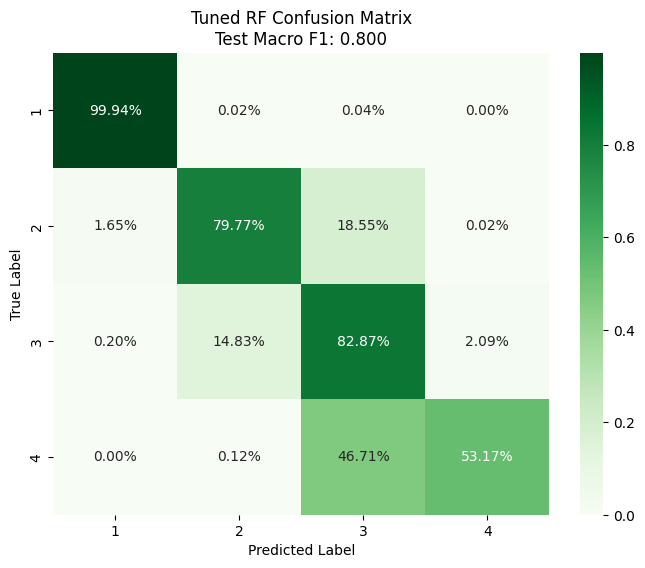

In [19]:
# 4. Final Evaluation on Test Set
y_pred = best_rf.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
# Recall for Class 4 (High Danger)
recalls = recall_score(y_test, y_pred, average=None, labels=[1, 2, 3, 4])
class_4_recall = recalls[3] if len(recalls) >= 4 else 0.0
print(f"  Accuracy:       {acc:.2%}")
print(f"  Macro F1:       {macro_f1:.4f}")
print(f"  DL 4 Recall:    {class_4_recall:.2%}")

# Visuals
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['DL 1', 'DL 2', 'DL 3', 'DL 4/5']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['1', '2', '3', '4'],
            yticklabels=['1', '2', '3', '4'])
plt.title(f'Tuned RF Confusion Matrix\nTest Macro F1: {macro_f1:.3f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save for Final Comparison Table
rf_results = {
    'model': 'Random Forest (Tuned)',
    'macro_f1': macro_f1,
    'accuracy': acc,
    'class_4_recall': class_4_recall
}